
#Installation
---



In [1]:
from pathlib import Path
import os
from datetime import date
import re
import glob

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import box
import dask.dataframe as dd
pd.options.mode.chained_assignment = None

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
# Paths
p = Path('C:/Users/alexd/Dropbox/FFE')
pathShapefile = p / 'shapefile'
pathParquets = p / 'output'

print(len(os.listdir(pathParquets)))

2999


In [5]:
def read_and_concatenate_parquets(path=pathParquets):
    L = []
    files = pathParquets.glob('*scenario*')
    for file in files:
#         print(f'{file} loaded file \n {len(L)}/2999')
        pqt = dd.read_parquet(file, engine='pyarrow')
        L.append(pqt)
    df = dd.concat(L)
    return df

    
def count_fid_occurences(df): 
    count_df = df['source'].value_counts().compute()
    count_df = pd.DataFrame({'FID': count_df.index, 'count': count_df.values})
    count_df.to_parquet(str(pathShapefile) + '/' + f'CountBurn-{str(date.today())}.parquet', 
                        engine='auto', compression="GZIP")# could be datetime.now
    return count_df


def Merge(countDf,nameShapefile):
    gdfShape = gpd.read_file(pathShapefile / nameShapefile)
    gdfShape.insert(0, 'FID', range(0, len(gdfShape)))
    m = pd.merge(countConcatDf,gdfShape, how='left',on='FID')
    merged = countDf.merge(gdfShape, on=['FID'], how='left')
    return merged


def createShapefile(df):
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf.to_file(os.path.join(str(pathShapefile) + "/" + "BurnscenarioWellington.shp"))
    return gdf

**Create count files**

In [6]:
%%time
concatDf = read_and_concatenate_parquets()

countConcatDf = count_fid_occurences(concatDf)

mergedDf = Merge(countConcatDf, 'WellWHV_Buildings.shp')
countShape = createShapefile(mergedDf)

Wall time: 49.1 s


**Plot**

Text(0.5, 1, 'Finn burn count at meshblock level')

Text(0.5, 1, 'Burn count at individual building level')

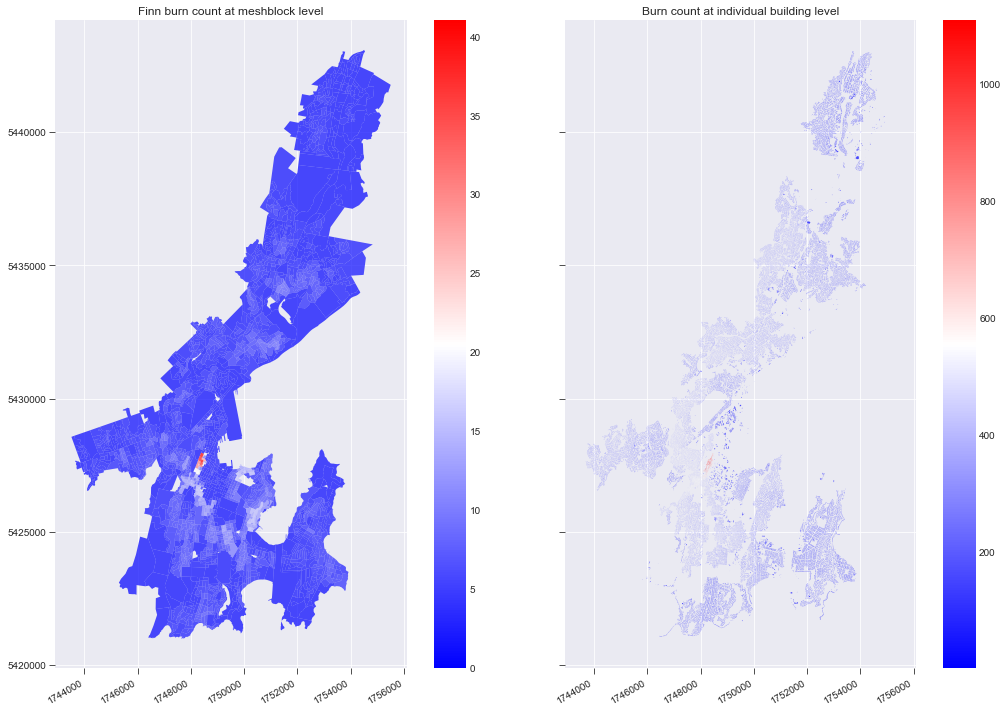

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
# import contextily as ctx
%matplotlib inline
plt.style.use('seaborn-darkgrid')

FinnMeshblockShape = gpd.read_file(pathShapefile / 'Finn_MeshBlockSummary.shp')
# countShape = gpd.read_file(pathShapefile / 'Burn3000scenarioWellington.shp')

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15, 10))

FinnMeshblockShape.plot(ax=ax1, column='WellWHV_Bu', cmap='bwr', alpha=0.7, legend=True)
# ctx.add_basemap(ax1, crs=2193)
countShape.plot(ax=ax2, column='count', cmap='bwr', alpha=0.7, legend=True)
# ctx.add_basemap(ax2, crs=2193)

ax1.set_title('Finn burn count at meshblock level')
ax1.ticklabel_format(useOffset=False, style='plain')
ax1.tick_params(direction='out', length=6)
ax2.set_title('Burn count at individual building level')
ax2.ticklabel_format(useOffset=False, style='plain')
ax2.tick_params(direction="out", length=6)

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig(pathShapefile / 'ComparisonGISvsNetwork_3000Burn.png', dpi=600)
plt.show()

**Plot distributions**

Text(0.5, 1.0, 'Distribution of fires')

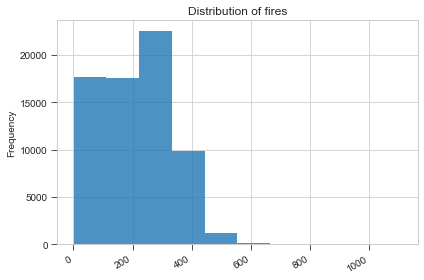

In [13]:
plt.style.use('seaborn-whitegrid')
fig, (ax1) = plt.subplots(nrows=1, ncols=1)#, figsize=(15, 10))

countConcatDf['count'].plot('hist', ax=ax1, alpha=0.8)

ax1.set_title('Distribution of fires')
ax1.ticklabel_format(useOffset=False, style='plain')
ax1.tick_params(direction="out", length=6)

fig.autofmt_xdate()
plt.tight_layout()
# plt.savefig(pathShapefile / 'ComparisonGISvsNetwork_3000Burn.png', dpi=600)
plt.show()

Text(0.5, 1.0, 'Distribution of ignitions')

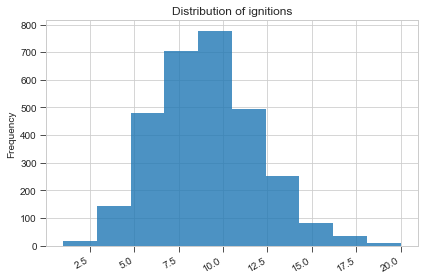

In [31]:
c = concatDf.drop_duplicates('scenario').compute()

plt.style.use('seaborn-whitegrid')
fig, (ax1) = plt.subplots(nrows=1, ncols=1)#, figsize=(15, 10))

c['InitialIgnitions'].plot('hist', ax=ax1, alpha=0.8)

ax1.set_title('Distribution of ignitions')
ax1.ticklabel_format(useOffset=False, style='plain')
ax1.tick_params(direction="out", length=6)

fig.autofmt_xdate()
plt.tight_layout()
# plt.savefig(pathShapefile / 'ComparisonGISvsNetwork_3000Burn.png', dpi=600)
plt.show()

**Loss calculation**

In [28]:
ccDf = concatDf[['source', 'scenario']].compute() 
ccDfLoss = pd.merge(ccDf, costData, how='left', left_on='source', right_on='FID') # would need to work with Dask !!
ccDflossCum = ccDfLoss.groupby(['scenario'])['Replacemen'].sum().reset_index()

In [83]:
# FinnLosses = np.array([0, 125000000, 263888888.9, 680555555.6, 1062500000, 1340277778, 2000000000, 
#               2555555556, 2972222222, 5020833333, 5402777778, 5854166667, 6305555556, 6444444444,
#               6965277778, 7243055556, 7381944444, 7902777778, 8145833333, 10263888889, 12347222222, 
#               13215277778, 14152777778])

# FinnProbability = np.array([0, 0.507380074, 0.556457565, 0.566789668, 0.584870849, 0.605535055, 
#                    0.719188192, 0.763099631, 0.770848708, 0.773431734, 0.804428044, 0.845756458,
#                    0.871586716, 0.871586716, 0.918081181, 0.923247232, 0.938745387, 0.949077491, 
#                    0.959409594, 0.972324723, 0.982656827, 0.985239852, 0.990405904])

pathFinn = Path('C:/Users/alexd/Dropbox/Work/GNS/008_FFE/ProbaFFE/OutputFinn')
dataFinn3000 = pd.read_csv(pathFinn / 'ScenSumWellWHV_pfour_1-3000.csv')

lossLevels = np.arange(1000, 100e9, 10000)
excMoreFinn = np.array([np.count_nonzero(dataFinn3000.ReplacementValue.values >= x) for x in lossLevels])/3000

In [98]:
max(dataFinn3000.ReplacementValue)/1e9
max(ccDflossCum.Replacemen)/1e9

7.114701276

21.787246149

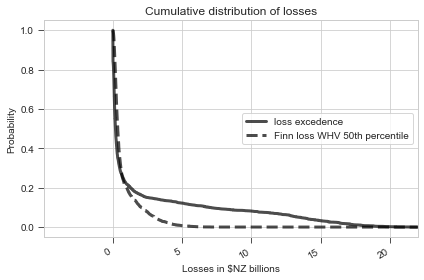

Wall time: 4min 24s


In [99]:
%%time
lossLevels = np.arange(1000, 100e9, 10000)
excLess = np.array([np.count_nonzero(ccDflossCum.Replacemen.values <= x) for x in lossLevels])/3000
excMore = np.array([np.count_nonzero(ccDflossCum.Replacemen.values >= x) for x in lossLevels])/3000


plt.style.use('seaborn-whitegrid')
fig, (ax1) = plt.subplots(nrows=1, ncols=1)#, figsize=(15, 10))

# ax1.plot(lossLevels/1e9, excLess, linewidth=2, linestyle='label='loss inferior')
ax1.plot(lossLevels/1e9, excMore, linewidth=3, linestyle='solid', alpha=0.7, color='black', label='loss excedence')
# ax1.plot(FinnLosses/1e9, FinnProbability, linewidth=2, linestyle='dashed', label='Finn loss report')
ax1.plot(lossLevels/1e9, excMoreFinn, linewidth=3, linestyle='dashed', alpha=0.7, color='black', label='Finn loss WHV 50th percentile')

ax1.set_title('Cumulative distribution of losses')
ax1.ticklabel_format(useOffset=False, style= 'scientific')
ax1.tick_params(direction="out", length=6)
ax1.legend(loc="center right", frameon=True)
ax1.set(xlabel="Losses in $NZ billions", ylabel="Probability")
# ax1.set_xscale('log')
ax1.set_xlim([None, 22])

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig(pathShapefile / 'ExcLosses.png', dpi=600)
plt.show()


(array([158.,  63.,  34.,  35.,  35.,  31.,  24.,  19.,  12.,  21.,  22.,
         35.,  33.,  35.,  25.,  22.,  25.,  13.,   8.,   3.,   2.,   0.,
          0.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24]),
 <a list of 23 Patch objects>)

(array([292., 156.,  88.,  42.,  16.,   3.,   3.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24]),
 <a list of 23 Patch objects>)

Text(0.5, 1.0, 'Distribution of losses')

Text(0.5, 0, 'Loss billions $NZ')

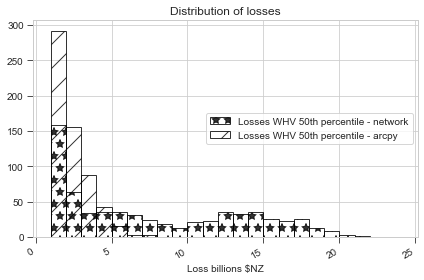

In [106]:
plt.style.use('seaborn-whitegrid')
fig, (ax1) = plt.subplots(nrows=1, ncols=1)#, figsize=(15, 10))

billionLossAlex = ccDflossCum.Replacemen / 1e9
billionLossFinn = dataFinn3000.ReplacementValue / 1e9

# ccDflossCum.Replacemen.plot('hist', alpha=0.8)
ax1.hist(billionLossAlex, bins=np.arange(1,25), fill=False, hatch='*', color='black', alpha=0.8, label='Losses WHV 50th percentile - network')
ax1.hist(billionLossFinn, bins=np.arange(1,25), fill=False, hatch='/', color='black', alpha=0.8, label='Losses WHV 50th percentile - arcpy')

ax1.set_title('Distribution of losses')
ax1.ticklabel_format(useOffset=False, style= 'scientific')
ax1.tick_params(direction="out", length=6)
# ax1.set_yscale('log')
ax1.set_xlabel('Loss billions $NZ')
ax1.legend(loc="center right", frameon=True)

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig(pathShapefile / 'DistributionLosses.png', dpi=600)
plt.show()